In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#Data path
data_directory = "/content/drive/MyDrive/BrainTumorMRIClassification/Data"

#Define transformations
transform = transforms.Compose([
    transforms.Resize((64,64)), # Ensure all images are same size, also smaller size for quicker training
    transforms.Grayscale(num_output_channels=1), # ensures grayscale
    transforms.ToTensor(), #Converts PIL image to Pytorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5]) # scales pixel values(for faster convergence) we normalize grayscale
])

# Load the dataset
train_data = datasets.ImageFolder(root=os.path.join(data_directory, "Training"), transform=transform)
test_data = datasets.ImageFolder(root=os.path.join(data_directory, "Testing"), transform=transform)

# Create Dataloaders
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


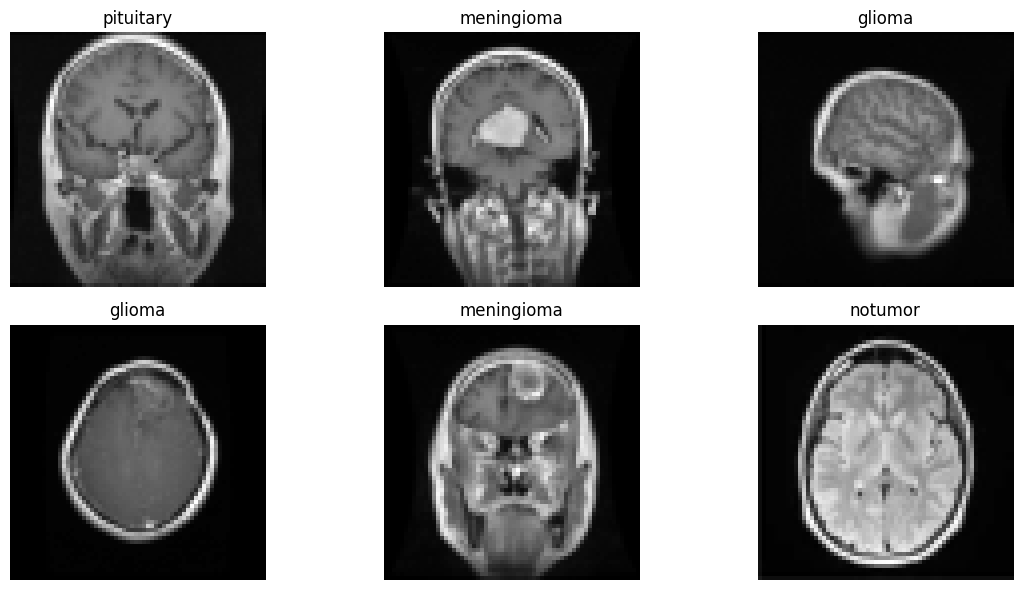

In [3]:
#Visualize some samples
import matplotlib.pyplot as plt
import numpy as np

#Get classes names from dataset
class_names = train_data.classes
print("Classes:", class_names)

#Get one batch of images and labels
images, labels = next(iter(train_loader))

#Unnormalize and show image
def show_image(img):
  img = img * 0.5 + 0.5 # Undo normalization
  np_img = img.squeeze().numpy()
  plt.imshow(np_img, cmap="gray")
  plt.axis("off")

#Plot first 6 images
plt.figure(figsize=(12,6))
for i in range(6):
  plt.subplot(2,3,i+1)
  show_image(images[i])
  plt.title(class_names[labels[i]])
plt.tight_layout()
plt.show()

In [4]:
import torch
import torch.nn as nn

class BrainTumorCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(16,32,kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32,64,kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64 * 8 * 8, 128),
        nn.ReLU(),
       # nn.Dropout(p=0.5),
        nn.Linear(128, 4)
    )

  def forward(self,x):
    x = self.conv_layer(x)
    x = self.classifier(x)
    return(x)

model = BrainTumorCNN()
model

BrainTumorCNN(
  (conv_layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BrainTumorCNN().to(device)


In [6]:
# Setup loss function and optimizeer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

#Set measure for accuracy
from torchmetrics import Accuracy
accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

In [7]:
from tqdm.notebook import tqdm

In [8]:
#training loop
epochs = 10

for epoch in range(epochs):
  model.train()
  accuracy.reset()
  train_loss = 0
  train_acc = 0

  loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
  for X_batch, y_batch in loop:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    optimizer.zero_grad()
    logits = model(X_batch)
    preds = torch.argmax(logits, dim=1)
    loss = loss_fn(logits, y_batch)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_acc += accuracy(preds, y_batch).item()
    loop.set_postfix(loss=loss.item(), acc=accuracy(preds, y_batch).item())
  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  # Testing phase
  model.eval()
  accuracy.reset()
  test_loss = 0
  test_acc= 0
  with torch.inference_mode():
    for i, (X_batch, y_batch) in enumerate(test_loader):
        print(f"Testing batch {i+1}/{len(test_loader)}")
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits_test = model(X_batch)
        preds_test = torch.argmax(logits_test, dim=1)
        loss = loss_fn(logits_test, y_batch)
        test_loss += loss.item()
        test_acc += accuracy(preds_test, y_batch).item()
  test_loss /= len(test_loader)
  test_acc /= len(test_loader)

  print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1/10:   0%|          | 0/179 [00:00<?, ?it/s]

Testing batch 1/41
Testing batch 2/41
Testing batch 3/41
Testing batch 4/41
Testing batch 5/41
Testing batch 6/41
Testing batch 7/41
Testing batch 8/41
Testing batch 9/41
Testing batch 10/41
Testing batch 11/41
Testing batch 12/41
Testing batch 13/41
Testing batch 14/41
Testing batch 15/41
Testing batch 16/41
Testing batch 17/41
Testing batch 18/41
Testing batch 19/41
Testing batch 20/41
Testing batch 21/41
Testing batch 22/41
Testing batch 23/41
Testing batch 24/41
Testing batch 25/41
Testing batch 26/41
Testing batch 27/41
Testing batch 28/41
Testing batch 29/41
Testing batch 30/41
Testing batch 31/41
Testing batch 32/41
Testing batch 33/41
Testing batch 34/41
Testing batch 35/41
Testing batch 36/41
Testing batch 37/41
Testing batch 38/41
Testing batch 39/41
Testing batch 40/41
Testing batch 41/41
Epoch 1/10 | Train Loss: 0.8105, Train Acc: 0.6749 | Test Loss: 0.6698, Test Acc: 0.7332


Epoch 2/10:   0%|          | 0/179 [00:00<?, ?it/s]

Testing batch 1/41
Testing batch 2/41
Testing batch 3/41
Testing batch 4/41
Testing batch 5/41
Testing batch 6/41
Testing batch 7/41
Testing batch 8/41
Testing batch 9/41
Testing batch 10/41
Testing batch 11/41
Testing batch 12/41
Testing batch 13/41
Testing batch 14/41
Testing batch 15/41
Testing batch 16/41
Testing batch 17/41
Testing batch 18/41
Testing batch 19/41
Testing batch 20/41
Testing batch 21/41
Testing batch 22/41
Testing batch 23/41
Testing batch 24/41
Testing batch 25/41
Testing batch 26/41
Testing batch 27/41
Testing batch 28/41
Testing batch 29/41
Testing batch 30/41
Testing batch 31/41
Testing batch 32/41
Testing batch 33/41
Testing batch 34/41
Testing batch 35/41
Testing batch 36/41
Testing batch 37/41
Testing batch 38/41
Testing batch 39/41
Testing batch 40/41
Testing batch 41/41
Epoch 2/10 | Train Loss: 0.4594, Train Acc: 0.8270 | Test Loss: 0.4946, Test Acc: 0.7995


Epoch 3/10:   0%|          | 0/179 [00:00<?, ?it/s]

Testing batch 1/41
Testing batch 2/41
Testing batch 3/41
Testing batch 4/41
Testing batch 5/41
Testing batch 6/41
Testing batch 7/41
Testing batch 8/41
Testing batch 9/41
Testing batch 10/41
Testing batch 11/41
Testing batch 12/41
Testing batch 13/41
Testing batch 14/41
Testing batch 15/41
Testing batch 16/41
Testing batch 17/41
Testing batch 18/41
Testing batch 19/41
Testing batch 20/41
Testing batch 21/41
Testing batch 22/41
Testing batch 23/41
Testing batch 24/41
Testing batch 25/41
Testing batch 26/41
Testing batch 27/41
Testing batch 28/41
Testing batch 29/41
Testing batch 30/41
Testing batch 31/41
Testing batch 32/41
Testing batch 33/41
Testing batch 34/41
Testing batch 35/41
Testing batch 36/41
Testing batch 37/41
Testing batch 38/41
Testing batch 39/41
Testing batch 40/41
Testing batch 41/41
Epoch 3/10 | Train Loss: 0.3547, Train Acc: 0.8708 | Test Loss: 0.4499, Test Acc: 0.8201


Epoch 4/10:   0%|          | 0/179 [00:00<?, ?it/s]

Testing batch 1/41
Testing batch 2/41
Testing batch 3/41
Testing batch 4/41
Testing batch 5/41
Testing batch 6/41
Testing batch 7/41
Testing batch 8/41
Testing batch 9/41
Testing batch 10/41
Testing batch 11/41
Testing batch 12/41
Testing batch 13/41
Testing batch 14/41
Testing batch 15/41
Testing batch 16/41
Testing batch 17/41
Testing batch 18/41
Testing batch 19/41
Testing batch 20/41
Testing batch 21/41
Testing batch 22/41
Testing batch 23/41
Testing batch 24/41
Testing batch 25/41
Testing batch 26/41
Testing batch 27/41
Testing batch 28/41
Testing batch 29/41
Testing batch 30/41
Testing batch 31/41
Testing batch 32/41
Testing batch 33/41
Testing batch 34/41
Testing batch 35/41
Testing batch 36/41
Testing batch 37/41
Testing batch 38/41
Testing batch 39/41
Testing batch 40/41
Testing batch 41/41
Epoch 4/10 | Train Loss: 0.2828, Train Acc: 0.8947 | Test Loss: 0.3274, Test Acc: 0.8567


Epoch 5/10:   0%|          | 0/179 [00:00<?, ?it/s]

Testing batch 1/41
Testing batch 2/41
Testing batch 3/41
Testing batch 4/41
Testing batch 5/41
Testing batch 6/41
Testing batch 7/41
Testing batch 8/41
Testing batch 9/41
Testing batch 10/41
Testing batch 11/41
Testing batch 12/41
Testing batch 13/41
Testing batch 14/41
Testing batch 15/41
Testing batch 16/41
Testing batch 17/41
Testing batch 18/41
Testing batch 19/41
Testing batch 20/41
Testing batch 21/41
Testing batch 22/41
Testing batch 23/41
Testing batch 24/41
Testing batch 25/41
Testing batch 26/41
Testing batch 27/41
Testing batch 28/41
Testing batch 29/41
Testing batch 30/41
Testing batch 31/41
Testing batch 32/41
Testing batch 33/41
Testing batch 34/41
Testing batch 35/41
Testing batch 36/41
Testing batch 37/41
Testing batch 38/41
Testing batch 39/41
Testing batch 40/41
Testing batch 41/41
Epoch 5/10 | Train Loss: 0.2360, Train Acc: 0.9117 | Test Loss: 0.3043, Test Acc: 0.8811


Epoch 6/10:   0%|          | 0/179 [00:00<?, ?it/s]

Testing batch 1/41
Testing batch 2/41
Testing batch 3/41
Testing batch 4/41
Testing batch 5/41
Testing batch 6/41
Testing batch 7/41
Testing batch 8/41
Testing batch 9/41
Testing batch 10/41
Testing batch 11/41
Testing batch 12/41
Testing batch 13/41
Testing batch 14/41
Testing batch 15/41
Testing batch 16/41
Testing batch 17/41
Testing batch 18/41
Testing batch 19/41
Testing batch 20/41
Testing batch 21/41
Testing batch 22/41
Testing batch 23/41
Testing batch 24/41
Testing batch 25/41
Testing batch 26/41
Testing batch 27/41
Testing batch 28/41
Testing batch 29/41
Testing batch 30/41
Testing batch 31/41
Testing batch 32/41
Testing batch 33/41
Testing batch 34/41
Testing batch 35/41
Testing batch 36/41
Testing batch 37/41
Testing batch 38/41
Testing batch 39/41
Testing batch 40/41
Testing batch 41/41
Epoch 6/10 | Train Loss: 0.1957, Train Acc: 0.9279 | Test Loss: 0.2888, Test Acc: 0.8788


Epoch 7/10:   0%|          | 0/179 [00:00<?, ?it/s]

Testing batch 1/41
Testing batch 2/41
Testing batch 3/41
Testing batch 4/41
Testing batch 5/41
Testing batch 6/41
Testing batch 7/41
Testing batch 8/41
Testing batch 9/41
Testing batch 10/41
Testing batch 11/41
Testing batch 12/41
Testing batch 13/41
Testing batch 14/41
Testing batch 15/41
Testing batch 16/41
Testing batch 17/41
Testing batch 18/41
Testing batch 19/41
Testing batch 20/41
Testing batch 21/41
Testing batch 22/41
Testing batch 23/41
Testing batch 24/41
Testing batch 25/41
Testing batch 26/41
Testing batch 27/41
Testing batch 28/41
Testing batch 29/41
Testing batch 30/41
Testing batch 31/41
Testing batch 32/41
Testing batch 33/41
Testing batch 34/41
Testing batch 35/41
Testing batch 36/41
Testing batch 37/41
Testing batch 38/41
Testing batch 39/41
Testing batch 40/41
Testing batch 41/41
Epoch 7/10 | Train Loss: 0.1599, Train Acc: 0.9387 | Test Loss: 0.2306, Test Acc: 0.9101


Epoch 8/10:   0%|          | 0/179 [00:00<?, ?it/s]

Testing batch 1/41
Testing batch 2/41
Testing batch 3/41
Testing batch 4/41
Testing batch 5/41
Testing batch 6/41
Testing batch 7/41
Testing batch 8/41
Testing batch 9/41
Testing batch 10/41
Testing batch 11/41
Testing batch 12/41
Testing batch 13/41
Testing batch 14/41
Testing batch 15/41
Testing batch 16/41
Testing batch 17/41
Testing batch 18/41
Testing batch 19/41
Testing batch 20/41
Testing batch 21/41
Testing batch 22/41
Testing batch 23/41
Testing batch 24/41
Testing batch 25/41
Testing batch 26/41
Testing batch 27/41
Testing batch 28/41
Testing batch 29/41
Testing batch 30/41
Testing batch 31/41
Testing batch 32/41
Testing batch 33/41
Testing batch 34/41
Testing batch 35/41
Testing batch 36/41
Testing batch 37/41
Testing batch 38/41
Testing batch 39/41
Testing batch 40/41
Testing batch 41/41
Epoch 8/10 | Train Loss: 0.1185, Train Acc: 0.9578 | Test Loss: 0.2347, Test Acc: 0.9070


Epoch 9/10:   0%|          | 0/179 [00:00<?, ?it/s]

Testing batch 1/41
Testing batch 2/41
Testing batch 3/41
Testing batch 4/41
Testing batch 5/41
Testing batch 6/41
Testing batch 7/41
Testing batch 8/41
Testing batch 9/41
Testing batch 10/41
Testing batch 11/41
Testing batch 12/41
Testing batch 13/41
Testing batch 14/41
Testing batch 15/41
Testing batch 16/41
Testing batch 17/41
Testing batch 18/41
Testing batch 19/41
Testing batch 20/41
Testing batch 21/41
Testing batch 22/41
Testing batch 23/41
Testing batch 24/41
Testing batch 25/41
Testing batch 26/41
Testing batch 27/41
Testing batch 28/41
Testing batch 29/41
Testing batch 30/41
Testing batch 31/41
Testing batch 32/41
Testing batch 33/41
Testing batch 34/41
Testing batch 35/41
Testing batch 36/41
Testing batch 37/41
Testing batch 38/41
Testing batch 39/41
Testing batch 40/41
Testing batch 41/41
Epoch 9/10 | Train Loss: 0.0995, Train Acc: 0.9660 | Test Loss: 0.1689, Test Acc: 0.9474


Epoch 10/10:   0%|          | 0/179 [00:00<?, ?it/s]

Testing batch 1/41
Testing batch 2/41
Testing batch 3/41
Testing batch 4/41
Testing batch 5/41
Testing batch 6/41
Testing batch 7/41
Testing batch 8/41
Testing batch 9/41
Testing batch 10/41
Testing batch 11/41
Testing batch 12/41
Testing batch 13/41
Testing batch 14/41
Testing batch 15/41
Testing batch 16/41
Testing batch 17/41
Testing batch 18/41
Testing batch 19/41
Testing batch 20/41
Testing batch 21/41
Testing batch 22/41
Testing batch 23/41
Testing batch 24/41
Testing batch 25/41
Testing batch 26/41
Testing batch 27/41
Testing batch 28/41
Testing batch 29/41
Testing batch 30/41
Testing batch 31/41
Testing batch 32/41
Testing batch 33/41
Testing batch 34/41
Testing batch 35/41
Testing batch 36/41
Testing batch 37/41
Testing batch 38/41
Testing batch 39/41
Testing batch 40/41
Testing batch 41/41
Epoch 10/10 | Train Loss: 0.0750, Train Acc: 0.9726 | Test Loss: 0.1701, Test Acc: 0.9520


In [9]:
from sklearn.metrics import classification_report, confusion_matrix

all_preds = []
all_labels = []
model.eval()
with torch.inference_mode():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = torch.argmax(model(X_batch), dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

print(confusion_matrix(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=class_names))


[[269  28   0   3]
 [ 14 279   8   5]
 [  0   0 405   0]
 [  2   3   0 295]]
              precision    recall  f1-score   support

      glioma       0.94      0.90      0.92       300
  meningioma       0.90      0.91      0.91       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.97      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



In [14]:
from PIL import Image

def predict_image(image_path, model, transform, class_names):
    # Load and preprocess an image
    image = Image.open(image_path).convert('L')  # grayscale
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Inference mode
    model.eval()
    with torch.inference_mode():
        output = model(image)
        prediction = torch.argmax(output, dim=1)
        predicted_class = class_names[prediction.item()]

    return predicted_class

In [28]:
# path of image for inference
image_path = "/content/drive/MyDrive/BrainTumorMRIClassification/Data/inference-meningioma2.jpg"

# Predict
predicted_class = predict_image(image_path, model, transform, class_names)
print(f"Predicted class: {predicted_class}")

Predicted class: meningioma
